In [2]:
# --- Environment Setup ---
%load_ext autoreload
%autoreload 2

import os
import sys
from datetime import date

# Ensure project root is in path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Scientific computing stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# FinOpt Core Modules
from src.income import FixedIncome, VariableIncome, IncomeModel
from src.expenses import FixedExpense, VariableExpense, ExpenseModel
from src.rewards import Reward, RewardSchedule
from src.portfolio import Account
from src.model import FinancialModel
from src.optimization import CVaROptimizer
from src.goals import IntermediateGoal, TerminalGoal, GoalSet

# Plotting configuration
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

## 2. Advanced Stochastic Income Modeling

We model a complex income structure typical of a high-earning professional:

1. **Fixed Salary**: Deterministic base with annual inflation adjustment and discrete career jumps (promotions).
2. **Variable Bonus**: Stochastic component with:
   - **Seasonality**: Higher in Q4/Dec (Christmas/End-of-year bonuses)
   - **Volatility**: $\sigma = 15\%$
   - **Growth**: Tied to inflation

### 2.1 Configuration

In [3]:
# --- 1. Fixed Income Streams ---

# Primary Salary: 2.5M CLP, grows 3%/year. Promotion (+500k) in 2 years.
salary = FixedIncome(
    base=2_500_000, 
    annual_growth=0.03,
    salary_raises={
        date(2028, 1, 1): 500_000,  # Promotion to Senior
        date(2030, 1, 1): 600_000   # Promotion to Lead
    },
    name="Salary (Primary)"
)

# Secondary Income (e.g., Rental Property): 600k/mo, index-linked
rental_income = FixedIncome(
    base=600_000,
    annual_growth=0.03, # Inflation adjustment
    salary_raises={
        date(2029, 1, 1): 50_000    # Contract renegotiation
    },
    name="Rental Income"
)

# --- 2. Variable Income Streams ---

# Annual Bonus: High seasonality in Dec (3.0x), 15% vol
seasonality_bonus = [0.1, 0.1, 0.1, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 3.0]
bonus = VariableIncome(
    base=300_000, # Monthly average equivalent
    seasonality=seasonality_bonus,
    sigma=0.15,
    floor=0,
    cap=5_000_000,
    seed=42,
    name="Corporate Bonus"
)

# Freelance / Consulting: Irregular, random, but valuable
# Higher volatility (30%), some Q4 seasonality
seasonality_freelance = [0.8, 0.9, 1.0, 1.0, 1.1, 1.0, 0.9, 0.8, 1.0, 1.2, 1.5, 0.8]
freelance = VariableIncome(
    base=500_000,
    seasonality=seasonality_freelance,
    sigma=0.30,
    floor=0,
    cap=1_500_000,
    seed=101,
    name="Consulting Side-Gig"
)

# Combine ALL into IncomeModel
income_model = IncomeModel(
    fixed=[salary, rental_income], 
    variable=[bonus, freelance]
)

print("Income Model Configured:")
print(f"  Fixed: Salary (${salary.base:,.0f}) + Rental (${rental_income.base:,.0f})")
print(f"  Variable: Bonus (avg ${bonus.base:,.0f}) + Freelance (avg ${freelance.base:,.0f})")

Income Model Configured:
  Fixed: Salary ($2,500,000) + Rental ($600,000)
  Variable: Bonus (avg $300,000) + Freelance (avg $500,000)


### 2.2 Income Projection (Monte Carlo)

We visualize the stochastic income trajectories. Notice the widening confidence intervals over time (compounding uncertainty) and the sharp peaks from seasonality.

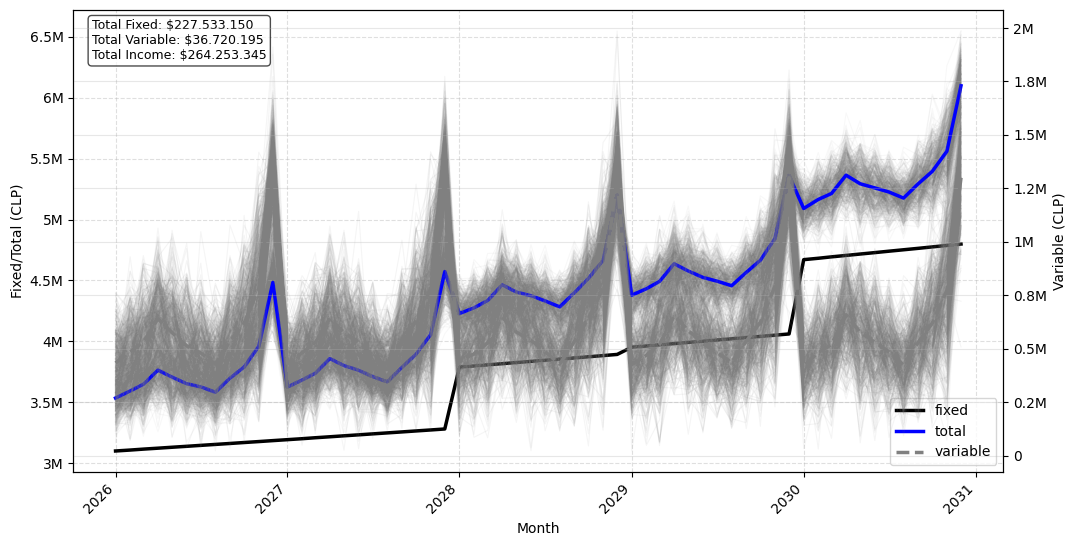

In [5]:
# Visualize Income Dynamics
# We create a temporary FinancialModel just for plotting income
# The model requires at least one account, so we create a dummy one
dummy_account = Account.from_annual("Dummy", 0.05, 0.1, initial_wealth=0)
temp_model = FinancialModel(income=income_model, accounts=[dummy_account])

temp_model.plot(
    mode="income", 
    T=60, 
    start=date(2026, 1, 1), 
    n_sims=500
)

## 3. Expense Modeling and Net Cashflow

Real-world wealth planning must account for liabilities. Expenses reduce the **disposable income** available for contribution.

### 3.1 Expense Structure
- **Fixed**: Rent/Mortgage, Basic Services
- **Variable**: Recreation, Travel, Unexpected costs

$$
A_t = \max(0, I_t^{\text{Total}} - E_t^{\text{Total}})
$$

In [ ]:
# --- Expanded Expense Modeling ---

# 1. Housing & Utilities
rent = FixedExpense(base=1_100_000, annual_inflation=0.03, name="Rent/Mortgage")
utilities = FixedExpense(base=150_000, annual_inflation=0.03, name="Utilities (Water/Elec/Gas)")
internet = FixedExpense(base=40_000, annual_inflation=0.02, name="Internet/Fiber")

# 2. Living Costs
groceries = FixedExpense(base=400_000, annual_inflation=0.04, name="Groceries")
transport = FixedExpense(base=100_000, annual_inflation=0.04, name="Transport/Fuel")

# 3. Insurance & subscriptions
insurance = FixedExpense(base=120_000, annual_inflation=0.05, name="Health/Life Insurance")
subscriptions = FixedExpense(base=50_000, annual_inflation=0.02, name="Netflix/Spotify/Gym")

# 4. "Fun" Money (Modeled as simpler fixed budget for now, could be variable)
entertainment = FixedExpense(base=300_000, annual_inflation=0.03, name="Dining/Entertainment")

# Consolidate all expenses
all_expenses = [
    rent, utilities, internet, 
    groceries, transport, 
    insurance, subscriptions, 
    entertainment
]

fixed_exp = ExpenseModel(fixed=all_expenses)

# Integrate expenses into IncomeModel
income_model.expenses = fixed_exp

# Check Net Disposable Income
print("Expense Integration (Expanded):")
gross = income_model.project(12, start=date(2026,1,1), output="dataframe")["total"].sum()
total_exp = fixed_exp.project(12, start=date(2026,1,1))["total"].sum()
net_disposable = gross - total_exp

print(f"  Annual Gross Income: ${gross:,.0f}")
print(f"  Annual Expenses:     ${total_exp:,.0f} (Avg ${total_exp/12:,.0f}/mo)")
print(f"  Net Disposable:      ${net_disposable:,.0f} ({net_disposable/gross:.1%})")

## 4. Withdrawal Rewards: "Splurges"

Unlike regular expenses (which reduce contributions), **Rewards** are lump-sum withdrawals directly from accumulated wealth. These represent major purchases (Cars, Travel, Weddings).

We model withdrawals matrix $Y \in \mathbb{R}^{T \times M}$ where $Y_{t,m}$ is the amount withdrawn from account $m$ at time $t$.

In [ ]:
import importlib
import src.rewards
importlib.reload(src.rewards)
from src.rewards import Reward, RewardSchedule

# Define Rewards (One-off withdrawals) - More "Splurges"

rewards = RewardSchedule(rewards=[
    # 1. Travel
    Reward(amount=4_000_000, month=18, name="EuroTrip 2027"),
    Reward(amount=2_500_000, month=42, name="Japan Trip 2029"),
    
    # 2. Tech & Gadgets
    Reward(amount=2_000_000, month=6, name="High-End Laptop"),
    Reward(amount=1_200_000, month=24, name="New iPhone/Tech"),
    
    # 3. Life Events
    Reward(amount=8_500_000, month=36, name="Car Upgrade"),
    Reward(amount=1_000_000, month=12, name="Sister's Wedding Gift"),
    Reward(amount=5_000_000, month=60, name="Home Renovation Phase 1")
])

print(f"Planned Rewards ({len(rewards.rewards)} events):")
for r in sorted(rewards.rewards, key=lambda x: x.month):
    print(f"  Month {r.month:<3} | ${r.amount/1e6:4.1f}M | {r.name}")

## 5. Portfolio Construction

We define a diverse set of accounts with varying risk-return profiles ($(\mu, \sigma)$). Correlations are crucial for diversification.

In [ ]:
# --- Expanded Portfolio Construction ---

accounts = [
    # 1. Safe / Liquid
    Account.from_annual("Checking (Cash)", 0.0, 0.0, initial_wealth=2_000_000),
    Account.from_annual("High Yield Savings", 0.04, 0.01, initial_wealth=5_000_000),
    
    # 2. Fixed Income
    Account.from_annual("Gov Bonds (UF)", 0.03, 0.04, initial_wealth=8_000_000),
    Account.from_annual("Corp Bonds", 0.06, 0.06, initial_wealth=3_000_000),
    
    # 3. Equities & Growth
    Account.from_annual("Global Equity ETF", 0.10, 0.15, initial_wealth=5_000_000),
    Account.from_annual("Tech Sector ETF", 0.14, 0.22, initial_wealth=2_000_000),
    
    # 4. Alternatives (High Risk)
    Account.from_annual("Crypto / Speculative", 0.25, 0.60, initial_wealth=500_000),
    Account.from_annual("REIT (Real Estate)", 0.08, 0.10, initial_wealth=1_000_000)
]

# Correlation Matrix (8x8)
# We construct a synthetic correlation structure:
# - Cash/Bonds: Low correlation
# - Equities: High correlation between them
# - Crypto: Low correlation to traditional, very high vol
# - REIT: Moderate correlation to equities
# 
# Order: Cash, HYS, GovBond, CorpBond, GlobEq, TechEq, Crypto, REIT
#          0     1     2        3         4       5       6      7
corr_matrix = np.array([
    # Cash  HYS   Gov   Corp  Glob  Tech  Cryp  REIT
    [1.00, 0.80, 0.20, 0.10, 0.05, 0.00, 0.05, 0.10], # Cash
    [0.80, 1.00, 0.30, 0.20, 0.10, 0.05, 0.05, 0.15], # HYS
    [0.20, 0.30, 1.00, 0.70, 0.20, 0.10, 0.00, 0.30], # Gov Bond
    [0.10, 0.20, 0.70, 1.00, 0.50, 0.40, 0.10, 0.50], # Corp Bond
    [0.05, 0.10, 0.20, 0.50, 1.00, 0.85, 0.30, 0.60], # Global Eq
    [0.00, 0.05, 0.10, 0.40, 0.85, 1.00, 0.40, 0.50], # Tech Eq
    [0.05, 0.05, 0.00, 0.10, 0.30, 0.40, 1.00, 0.20], # Crypto
    [0.10, 0.15, 0.30, 0.50, 0.60, 0.50, 0.20, 1.00]  # REIT
])

# Full Financial Model
model = FinancialModel(
    income=income_model,
    accounts=accounts,
    default_correlation=corr_matrix,
    expenses=fixed_exp,
    rewards=rewards
)

print(f"Model initialized with {model.M} accounts.")
# Validate correlation matrix shape
assert corr_matrix.shape == (len(accounts), len(accounts))

## 6. Goal-Based Optimization (The "Main Event")

We specify a **Ladder of Goals**:
1. **Emergency Fund**: Maintenance of 5M liquid (Intermediate)
2. **Wedding Fund**: 12M needed in 2 years (Intermediate)
3. **Financial Freedom**: Accumulate 150M USD (Terminal, TBD)

The optimizer will find:
1. Minimum time $T^*$ to satisfy the terminal goal.
2. Optimal contribution policy $X^*$ that satisfies all intermediate goals along the way.

### 6.1 Goal Safety Margins ($ε$)
We use strict $\epsilon$ for near-term goals and relaxed $\epsilon$ for long-term goals.

In [ ]:
goals = [
    # 1. Safety Net: Ensure specific liquidity at M12
    IntermediateGoal(
        month=12,
        account="High Yield Savings", # Target the HYS account
        threshold=4_000_000, # Was 3M/5M, adjusted
        confidence=0.90
    ),
    
    # 2. Medium Term Project (e.g. Down payment help) at M30
    IntermediateGoal(
        month=30,
        account="Global Equity ETF", 
        threshold=6_000_000, # Was 12M/8M, reduced to be easier
        confidence=0.75
    ),
    
    # 3. Financial Independence Proxy (Terminal)
    # Reduced from 80M/150M to 40M to be more achievable with higher expenses
    TerminalGoal(
        account="Global Equity ETF", # Use broader market index for long term
        threshold=40_000_000,
        confidence=0.65
    )
]

print("Optimization Goals defined (Reduced Ambition).")

### 6.2 Solving the Bilevel Problem

We use **ECOS** solver via CVXPY. The outer loop searches for $T$, inner loop solves the CVaR-constrained allocation.

**Note:** This might take ~30-60 seconds depending on machine speed.

In [ ]:
optimizer = CVaROptimizer(n_accounts=model.M, objective="balanced")

print("Starting Optimization... (this performs binary search over T)")
result = model.optimize(
    goals=goals,
    optimizer=optimizer,
    T_max=120,      # Max search horizon (10 years)
    n_sims=300,     # Scenarios for optimization
    seed=42,
    verbose=True
)

print("\nOptimization Complete!")
print(result.summary())

## 7. Results Analysis & Visualization

### 7.1 Wealth Dynamics under Optimal Policy $X^*$

We verify the solution using an **out-of-sample** simulation with more scenarios ($N=1000$).
Notice how the wealth dips at month 18 and 36 due to the configured Rewards (Trip & Car).

In [ ]:
# Out-of-sample simulation
oos_sim = model.simulate_from_optimization(
    result,
    n_sims=1000,
    seed=999 # Fresh seed
)

# Plot Wealth Dynamics
model.plot(
    mode="wealth",
    result=oos_sim,
    X=result.X,
    goals=goals,
    title="Wealth Trajectories with Withdrawals & Goals"
)

### 7.2 Optimal Allocation Policy $X^*$

The heatmap below shows how the optimizer shifts contributions over time to meet specific deadlines. Often, it will prioritize safer accounts right before a deadline (gliding path).

In [ ]:
model.plot(
    mode="allocation",
    result=oos_sim,
    X=result.X,
    title="Optimal Contribution Policy Evolution"
)

### 7.3 Goal Satisfaction Verification

We rigorously check if the probability constraints hold out-of-sample. The violation rate should be $\le \epsilon$.

In [ ]:
validation = model.verify_goals(oos_sim, goals, start=date(2026, 1, 1))

print(f"{'Goal / Account':<40} | {'Req Conf':<10} | {'Actual':<10} | {'Status'}")
print("-"*80)

for goal, stats in validation.items():
    name = f"{goal.account} (M{goal.month})" if isinstance(goal, IntermediateGoal) else f"{goal.account} (Terminal)"
    req = f"{goal.confidence:.1%}"
    act = f"{1 - stats['violation_rate']:.1%}"
    status = "✅ PASS" if stats['satisfied'] else "❌ FAIL"
    
    print(f"{name:<40} | {req:<10} | {act:<10} | {status}")

## 8. Effect of "Splurges" (Rewards)

We can isolate the impact of the planned withdrawals (Trip/Car) by comparing a simulation **without** rewards against our baseline.

This helps quantify the "cost of living life" in terms of delayed financial independence.

In [ ]:
# Create counterfactual model without rewards
model_no_rewards = FinancialModel(
    income=income_model,
    accounts=accounts,
    default_correlation=corr_matrix,
    expenses=fixed_exp,
    rewards=None  # Remove rewards
)

# Simulate using the SAME policy X*
sim_no_rewards = model_no_rewards.simulate(
    T=result.T,
    n_sims=1000,
    X=result.X,
    seed=999
)

# Compare Final Total Wealth
wealth_base = oos_sim.wealth[:,-1,:].sum(axis=1)
wealth_counter = sim_no_rewards.wealth[:,-1,:].sum(axis=1)

diff = wealth_counter.mean() - wealth_base.mean()

print(f"Mean Final Wealth (With Rewards):    ${wealth_base.mean():,.0f}")
print(f"Mean Final Wealth (No Rewards):      ${wealth_counter.mean():,.0f}")
print(f"Cost of Rewards (Future Value):      ${diff:,.0f}")

plt.figure(figsize=(10, 6))
plt.hist(wealth_base/1e6, bins=50, alpha=0.6, label='With Rewards (Trip+Car)')
plt.hist(wealth_counter/1e6, bins=50, alpha=0.6, label='No Rewards (Frugal)')
plt.xlabel('Final Wealth ($ millions)')
plt.ylabel('Frequency')
plt.title('Impact of Withdrawals on Terminal Wealth Distribution')
plt.legend()
plt.show()

## 9. Comprehensive Timeline: Expenses, Rewards & Goals

We visualize the full cash outflow schedule (regular expenses + lumpsum rewards) and provide a chronological timeline of when key financial milestones (Goals) and expenditure events (Rewards) occur.

In [ ]:
# --- Visualization: Expenses vs. Rewards ---

# 1. Project Expenses (Mean)
T_plot = result.T
dates = pd.date_range(start=date(2026, 1, 1), periods=T_plot, freq="MS")
expense_proj = fixed_exp.project(T_plot, start=date(2026, 1, 1), output="dataframe")

fig, ax = plt.subplots(figsize=(12, 6))

# Plot Regular Expenses
ax.plot(dates, expense_proj["total"] / 1e6, label="Monthly Expenses", color="tab:blue", alpha=0.7)
ax.fill_between(dates, 0, expense_proj["total"] / 1e6, color="tab:blue", alpha=0.1)

# Plot Rewards (as Bars)
reward_dates = []
reward_amounts = []
reward_names = []

for r in rewards.rewards:
    if 0 < r.month <= T_plot:
        # Month 1 is index 0
        d = dates[r.month - 1]
        reward_dates.append(d)
        reward_amounts.append(r.amount / 1e6)
        reward_names.append(r.name)

if reward_dates:
    # Use bar chart for one-off rewards
    ax.bar(reward_dates, reward_amounts, width=20, color="crimson", alpha=0.6, label="One-off Rewards (Withdrawals)")
    
    # Annotate bars
    for d, amt, name in zip(reward_dates, reward_amounts, reward_names):
        ax.annotate(
            f"{name}\n${amt:.1f}M", 
            (d, amt), 
            xytext=(0, 5), 
            textcoords="offset points", 
            ha='center', 
            va='bottom',
            fontsize=9,
            color="darkred",
            fontweight='bold'
        )

ax.set_title("Cash Outflows: Recurring Expenses vs. One-off Rewards")
ax.set_ylabel("Amount (Millions CLP)")
ax.set_xlabel("Date")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)
plt.show()

In [ ]:
# --- Timeline Report: Goals & Rewards ---
from dateutil.relativedelta import relativedelta

start_date = date(2026, 1, 1)

print("FINANCIAL MILESTONE TIMELINE")
print("=" * 95)
print(f"{'Date':<12} | {'Month':<5} | {'Type':<12} | {'Description':<35} | {'Status / Value'}")
print("-" * 95)

events = []

# 1. Collect Rewards
for r in rewards.rewards:
    d = start_date + relativedelta(months=r.month - 1)
    events.append({
        "date": d,
        "month": r.month,
        "type": "💰 REWARD",
        "desc": r.name,
        "value": f"Withdraw ${r.amount/1e6:,.1f}M",
        "sort_key": (r.month, 0) # Sort by month, then type
    })

# 2. Collect Goals (using validation results)
# Only if validation exists
if 'validation' in locals():
    for goal, stats in validation.items():
        if isinstance(goal, IntermediateGoal):
            d = start_date + relativedelta(months=goal.month - 1)
            m = goal.month
            desc = f"{goal.account} > ${goal.threshold/1e6:.1f}M"
            
            # Check status
            is_met = stats['satisfied']
            prob = 1 - stats['violation_rate']
            status_icon = "✅" if is_met else "❌"
            status_text = f"{status_icon} Met (Prob: {prob:.0%})"
            
            events.append({
                "date": d,
                "month": m,
                "type": "🎯 GOAL (Int)",
                "desc": desc,
                "value": status_text,
                "sort_key": (m, 1)
            })
            
        elif isinstance(goal, TerminalGoal):
            # Terminal goal is at T* (result.T)
            d = start_date + relativedelta(months=result.T - 1)
            m = result.T
            desc = f"{goal.account} > ${goal.threshold/1e6:.1f}M"
            
            is_met = stats['satisfied']
            prob = 1 - stats['violation_rate']
            status_icon = "✅" if is_met else "❌"
            status_text = f"{status_icon} FINISHED (Prob: {prob:.0%})"
            
            events.append({
                "date": d,
                "month": m,
                "type": "🏁 GOAL (End)",
                "desc": desc,
                "value": status_text,
                "sort_key": (m, 1)
            })

# 3. Sort and Print
events.sort(key=lambda x: x["sort_key"])

for e in events:
    print(f"{e['date'].strftime('%Y-%m-%d'):<12} | {e['month']:<5} | {e['type']:<12} | {e['desc']:<35} | {e['value']}")